In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import patsy
from scipy.stats import zscore
import tableone as tb
import warnings

warnings.simplefilter(action='ignore')

from src.connectomics.atlases import get_dk_rois
from src.analysis.misc import set_plot_style

set_plot_style(dpi=150)
ROIs = get_dk_rois()

# in
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
df_dir = os.path.join(data_dir, 'datasets')

# out
media_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'media'))

plot_dir = os.path.join(media_dir, '_plots')
os.makedirs(plot_dir, exist_ok=True)

In [4]:
# LONG
ld_grp_col = 'tau_positive_bas'
amy_prefix = 'fnc'
tau_prefix = 'tnic'

df_ld = pd.read_csv(os.path.join(df_dir, f'bf2_tau_asymmetry_ad_long_{tau_prefix}_{amy_prefix}.csv'), low_memory=False, index_col=0)
df_ld['apoe4_count'] = df_ld['apoe_genotype_baseline_variable'].astype(str).apply(lambda x: np.nan if x is np.nan else sum(int(i == '4') for i in x))
# df_ld['gender_baseline_variable'] = df_ld['gender_baseline_variable'].map({0.0: 'M', 1.0: 'F'})

# sort by id and age
df_ld = df_ld.sort_values(['mid', 'age'])

# drop timepoints which dont have tau data and subjects with not multiple timepoints
df_ld = df_ld.dropna(subset='tnic_temporal_meta')
df_ld = df_ld[df_ld.groupby('mid')['mid'].transform('count') > 1]

# subjects who have more than 3 timepoints, in case the first timepoint doesnt have amyPET, set the second timepoint as first if that one has
def adjust_timepoints(group, column, min_length=3):
    if pd.isna(group.iloc[0][column]):
        if len(group) >= min_length:
            if pd.notna(group.iloc[1][column]):
                group = group.iloc[1:].reset_index(drop=True)
    return group
df_ld = df_ld.groupby('mid', as_index=False, group_keys=False).apply(lambda x: adjust_timepoints(x, 'fnc_global')).reset_index(drop=True)
print(f"N (multiple tau-PET scans) = {len(df_ld['mid'].unique())} (all timepoints = {len(df_ld)})")

# df with available baseline amyPET
df_ld_a = df_ld[df_ld.groupby('mid')['fnc_global'].transform(lambda x: x.iloc[0]).notna()]
print(f"N (has baseline amy-PET) = {len(df_ld_a['mid'].unique())} (all timepoints = {len(df_ld_a)})")

# set baseline values for all timepoints
df_ld_a[ld_grp_col] = df_ld_a.groupby('mid')['tau_positive'].transform(lambda x: x.iloc[0])
df_ld_a['time'] = df_ld_a.groupby('mid')['age'].transform(lambda x: x - x.iloc[0])
df_ld_a['age_bas'] = df_ld_a.groupby('mid')['age'].transform(lambda x: x.iloc[0])
df_ld_a['fnc_global_bas'] = df_ld_a.groupby('mid')['fnc_global'].transform(lambda x: x.iloc[0])
df_ld_a['tnic_temporal_meta_bas'] = df_ld_a.groupby('mid')['tnic_temporal_meta'].transform(lambda x: x.iloc[0])

# add the amount of timepoints for tau PET and if has amyloid PET at a timepoint
df_ld_a['tp_total'] = df_ld_a.groupby('mid')['mid'].transform('count')
df_ld_a['tp_tauPET'] = df_ld_a.groupby('mid')['tnic_temporal_meta'].transform(lambda x: x.notna().sum())
df_ld_a['has_amyPET'] = df_ld_a.groupby('mid')['fnc_global_bas'].transform(lambda x: x.notna().astype(int))

# divide to tau positive and negative samples
df_ld_a_tneg = df_ld_a[df_ld_a[ld_grp_col]==False]
df_ld_a_tpos = df_ld_a[df_ld_a[ld_grp_col]==True]

df_ld_a_tnegpos = df_ld_a_tneg.groupby('mid').filter(lambda x: x['tau_positive'].iloc[1:].any())
df_ld_a_tnegneg = df_ld_a_tneg.groupby('mid').filter(lambda x: ~x['tau_positive'].any())

plots_rois_dict = {
    'A+': {
        'df': df_ld_a, 
        'rois': {
            'global': 'Global', 
        }
    },
    'A+T-': {
        'df': df_ld_a_tneg, 
        'rois': {
            'cho_com_I_II': 'Braak I-II', 'cho_com_III_IV': 'Braak III-IV', 'cho_com_V_VI': 'Braak V-VI'
        }
    },
    'A+T+': {
        'df': df_ld_a_tpos, 
        'rois': {
            'cho_com_I_II': 'Braak I-II', 'cho_com_III_IV': 'Braak III-IV', 'cho_com_V_VI': 'Braak V-VI'
        }
    },
    'A+T- to A+T-': {
        'df': df_ld_a_tnegneg, 
        'rois': {
            'cho_com_I_II': 'Braak I-II', 'cho_com_III_IV': 'Braak III-IV', 'cho_com_V_VI': 'Braak V-VI'
        }
    },
    'A+T- to A+T+': {
        'df': df_ld_a_tnegpos, 
        'rois': {
            'cho_com_I_II': 'Braak I-II', 'cho_com_III_IV': 'Braak III-IV', 'cho_com_V_VI': 'Braak V-VI'
        }
    }
}

for grp, g_data in plots_rois_dict.items():
    df_ = g_data['df']
    print(f"N ({grp}) = {len(df_['mid'].unique())} (all timepoints = {len(df_)})")

# print(f"N (multiple tau-PET) = {len(df_ld_bas)} (all timepoints = {len(df_ld)})")
# # first timepoints only
# df_ld_bas = df_ld.drop_duplicates(subset='mid', keep='first')
# print(f"N (multiple tau-PET) = {len(df_ld_bas)} (all timepoints = {len(df_ld)})")
# df_ld_a_bas = df_ld_a.drop_duplicates(subset='mid', keep='first')
# print(f"N (multiple tau-PET + baseline amy-PET) = {len(df_ld_a_bas)} (all timepoints = {len(df_ld_a)})")

N (multiple tau-PET scans) = 402 (all timepoints = 949)
N (has baseline amy-PET) = 289 (all timepoints = 707)
N (A+) = 289 (all timepoints = 707)
N (A+T-) = 180 (all timepoints = 452)
N (A+T+) = 109 (all timepoints = 255)
N (A+T- to A+T-) = 142 (all timepoints = 347)
N (A+T- to A+T+) = 38 (all timepoints = 105)


In [5]:
df_ld_a_bas = df_ld_a.drop_duplicates(subset='mid', keep='first')
print(f"N (longitudinal A+ with Ab-PET) = {len(df_ld_a_bas)} (all timepoints = {len(df_ld_a)})")

df_ld_a_bas['gender_baseline_variable'] = df_ld_a_bas['gender_baseline_variable'].map({0.0: 'M', 1.0: 'F'})

var_order = ['tp_tauPET', 'age', 'gender_baseline_variable', 'education_level_years_baseline_variable', 'diagnosis_baseline_variable', 
             'tnic_temporal_meta', 'tnic_temporal_meta_LI', 'fnc_global', 'apoe4_count', 'mmse_score', 'mPACC_v2']
var_cont = ['age', 'education_level_years_baseline_variable', 'tnic_temporal_meta', 'tnic_temporal_meta_LI', 'fnc_global', 
            'mmse_score', 'mPACC_v2']
var_cat = ['gender_baseline_variable', 'diagnosis_baseline_variable', 'apoe4_count', 'tp_tauPET']
var_notnorm = ['tnic_temporal_meta', 'tnic_temporal_meta_LI' 'fnc_global', 'mmse_score', 'mPACC_v2']
cat_order = {'gender_baseline_variable': ['M', 'F'], 'diagnosis_baseline_variable': ['Normal', 'SCD', 'MCI', 'AD'], 
                'apoe4_count': ['0', '1', '2']}
rename_vars = {'age': 'Age', 'gender_baseline_variable': 'Sex', 'education_level_years_baseline_variable': 'Education years',
               'diagnosis_baseline_variable': 'Diagnosis', 'tnic_temporal_meta': 'Temporal tau load', 
               'tnic_temporal_meta_LI' : 'Temporal tau laterality index', 'fnc_global': 'Global Aβ load', 
               'apoe4_count': 'ApoE4 count', 'mmse_score': 'MMSE', 'mPACC_v2': 'mPACC'}

table = tb.TableOne(
    data=df_ld_a_bas.copy(),
    groupby=ld_grp_col, columns=var_order, categorical=var_cat, continuous=var_cont, include_null=True, # data
    rename=rename_vars, label_suffix=True, decimals=2, missing=True, overall=False, order=cat_order, # visual
    dip_test=True, normal_test=True, tukey_test=True, nonnormal=var_notnorm, htest_name=True, pval=True, pval_adjust=None, # stats
)

display(table)
table.to_excel(os.path.join(media_dir, 'ld_demographics.xlsx'))

N (longitudinal A+ with Ab-PET) = 289 (all timepoints = 707)


Grouped by tau_positive_bas                                                                                             
                                                                    Missing                False                 True P-Value                                       Test
n                                                                                            180                  109                                                   
tp_tauPET, n (%)                         2                                           107 (59.44)           78 (71.56)   0.178  Chi-squared (warning: expected count < 5)
                                         3                                            55 (30.56)           25 (22.94)                                                   
                                         4                                             17 (9.44)             6 (5.50)                                                   
                                         5                                              1 (0.56)                                                                        
Age, mean (SD)                                                            0         73.09 (7.89)         72.08 (7.06)   0.264                          Two Sample T-test
Sex, n (%)                               M                                            92 (51.11)           57 (52.29)   0.941                                Chi-squared
                                         F                                            88 (48.89)           52 (47.71)                                                   
Education years, mean (SD)                                                4         12.78 (4.08)         12.98 (3.68)   0.670                          Two Sample T-test
Diagnosis, n (%)                         Normal                                       61 (33.89)           13 (11.93)  <0.001  Chi-squared (warning: expected count < 5)
                                         SCD                                          55 (30.56)           23 (21.10)                                                   
                                         MCI                                          64 (35.56)           69 (63.30)                                                   
                                         AD                                                                  4 (3.67)                                                   
Temporal tau load, median [Q1,Q3]                                         0     1.19 [1.14,1.24]     1.61 [1.42,2.00]  <0.001                             Kruskal-Wallis
Temporal tau laterality index, mean (SD)                                  0         -0.26 (1.74)         -3.28 (9.81)   0.002                          Two Sample T-test
Global Aβ load, mean (SD)                                                 0          1.27 (0.19)          1.50 (0.20)  <0.001                          Two Sample T-test
ApoE4 count, n (%)                       0                                            62 (34.44)           17 (15.60)   0.001                                Chi-squared
                                         1                                            99 (55.00)           71 (65.14)                                                   
                                         2                                            19 (10.56)           21 (19.27)                                                   
MMSE, median [Q1,Q3]                                                      0  29.00 [27.00,29.25]  27.00 [26.00,29.00]  <0.001                             Kruskal-Wallis
mPACC, median [Q1,Q3]                                                     6  -0.56 [-1.53,-0.00]  -1.50 [-2.40,-0.63]  <0.001                             Kruskal-Wallis
[1] Hartigan's Dip Test reports possible
                                    multimodal distributions for: education_level_years_baseline_variable, mmse_score.
[

N (A+) = 289 (all timepoints = 707)


avg followup years = 2.874
           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: tnic_global_LI
No. Observations: 707     Method:             REML          
No. Groups:       289     Scale:              0.0531        
Min. group size:  2       Log-Likelihood:     -621.6468     
Max. group size:  5       Converged:          No            
Mean group size:  2.4                                       
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         -0.033    0.044 -0.742 0.458 -0.118  0.053
time               0.043    0.014  3.168 0.002  0.016  0.069
mid Var            0.506    0.167                           
mid x time Cov     0.024    0.042                           
time Var           0.036                                    



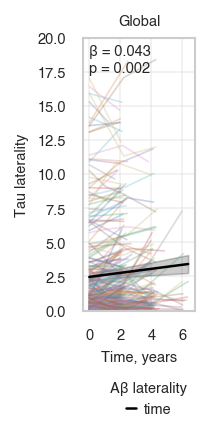

In [6]:
posthoc = True

ROIs_dict = {
    'global': 'Global', 
    'cho_com_I_II': 'Braak I-II', 'cho_com_III_IV': 'Braak III-IV', 'cho_com_V_VI': 'Braak V-VI',
}

plots_rois_dict_tauonly = {
    'A+': {
        'df': df_ld_a, 
        'rois': {
            'global': 'Global', 
        }
    }
}

set_plot_style(dpi=150)
statann_kwargs = dict(fontsize=7, color='#494949')
line_kwargs = dict(lw=0.8, alpha=0.3)
colors = ['#5785C1FF', '#A3B4C8', '#D3D4D8FF', '#D8B58C', '#E89826']
cmap = ListedColormap(colors, name="BlueToGrayToOrange")

for grp, grp_data in plots_rois_dict_tauonly.items():

    df_g = grp_data['df']
    rois_dict = grp_data['rois']

    print(f"N ({grp}) = {len(df_g['mid'].unique())} (all timepoints = {len(df_g)})")

    _w = 110/4.1
    _w_ratio = [*[1] * len(rois_dict), 0.1]

    fig = plt.figure(figsize=(_w*(len(rois_dict)+0.1)/25.4, 60/25.4))
    gs = fig.add_gridspec(1, len(rois_dict)+1, width_ratios=_w_ratio, wspace=0.2)
    axs = []
    for i in range(len(rois_dict)):
        axs.append(fig.add_subplot(gs[0, i]))

    for i, (ROI, ROI_name) in enumerate(rois_dict.items()):
        
        # define the tau and ab columns
        tau_reg = f'{tau_prefix}_{ROI}_LI'

        df_roi = df_g.copy()

        tau_lim = [0, 20]

        df_lme = df_roi[['mid', 'time', tau_reg]].copy()
        df_lme[tau_reg] = df_lme[tau_reg].abs()

        avg_fup = df_lme.groupby('mid')['time'].transform(lambda x: x.iloc[-1:]).mean()
        if i==0: print(f'avg followup years = {avg_fup:.3f}')

        # Store original values before z-scoring
        orig_means = df_lme[[f'{tau_reg}']].mean()
        orig_stds = df_lme[[f'{tau_reg}']].std()

        # Z-score the continuous variables
        cols_to_zscore = [f'{tau_reg}']
        df_lme_z = df_lme.copy()
        df_lme_z[cols_to_zscore] = df_lme_z[cols_to_zscore].apply(zscore)

        # fit the LME
        formula = f"{tau_reg} ~ time"
        model = smf.mixedlm(formula, data=df_lme_z, groups="mid", re_formula="~time")
        results = model.fit()

        print(results.summary())
        
        ### plotting

        ax = axs[i]

        # define time range for prediction
        time_min, time_max = df_lme['time'].min(), df_lme['time'].max()
        time_range = np.linspace(time_min, time_max, 100)

        # get covariance matrix of the fixed effects parameters
        fixed_effects_cov = results.cov_params().iloc[:2, :2] #[:6, :6]

        # plot the individual datapoints as spaghetti plot
        for subject in df_lme['mid'].unique():
            subject_data = df_lme[df_lme['mid'] == subject]
            ax.plot(subject_data['time'], subject_data[tau_reg],
                    **line_kwargs)
        
        # plt.ylim([-1.1*df_lme[tau_reg].abs().max(), 1.1*df_lme[tau_reg].abs().max()])
        ax.set_ylim(tau_lim)

        # run prediction
        # Create prediction data (z-scored)
        temp_data = pd.DataFrame({
            'time': time_range
        })

        # Get predictions and transform back to original scale
        pred_mean = results.predict(temp_data)
        pred_mean_orig = pred_mean * orig_stds[f'{tau_reg}'] + orig_means[f'{tau_reg}']

        # Calculate confidence intervals
        design_matrix = np.asarray(patsy.dmatrix(formula.split('~')[1], data=temp_data))
        prediction_var = np.diag(design_matrix @ fixed_effects_cov @ design_matrix.T)
        se = np.sqrt(prediction_var)

        # Transform CIs back to original scale
        lower_ci = (pred_mean - 1.96 * se) * orig_stds[f'{tau_reg}'] + orig_means[f'{tau_reg}']
        upper_ci = (pred_mean + 1.96 * se) * orig_stds[f'{tau_reg}'] + orig_means[f'{tau_reg}']

        # Plot
        ax.plot(time_range, pred_mean_orig, color='black', linewidth=1.2, label='time')
        ax.fill_between(time_range, lower_ci, upper_ci, color='black', alpha=0.2)
        
        if i > 0:
            ax.set_ylabel('')
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('Tau laterality')
        ax.set_title(ROI_name)

        # add annotation of the interaction effect
        interaction_idx = results.model.exog_names.index('time')
        beta = results.params[interaction_idx]
        pval = results.pvalues[interaction_idx]
        if posthoc: 
            pval = pval * len(rois_dict) # bonferroni correction
            if pval < 0.001: ptext = '< 0.001'
            elif pval > 0.9: ptext = '> 0.900'
            else: ptext = f'= {pval:.3f}'
        # ptext = '< 0.001' if pval < 0.001 else f'= {pval:.3f}'
        ax.text(0.055, 0.975, f'β = {beta:.3f}\np {ptext}',
                transform=ax.transAxes, verticalalignment='top')
        
        ax.set_xlim([-0.4, 6.8])
        ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
        ax.set_xlabel('Time, years')
        
        if i == 0: handles, labels = ax.get_legend_handles_labels()

    plt.legend(handles, labels, loc='lower center', frameon=False, title='Aβ laterality', title_fontsize=7, ncol=2,
                handlelength=0.75, handletextpad=0.5, labelspacing=0.5, bbox_to_anchor=(0.5, -0.225), bbox_transform=fig.transFigure)

    plt.tight_layout()
    # plt.savefig(os.path.join(plot_dir, f'LME_tau_ab_laterality_ld_{grp}_{list(rois_dict.keys())}.pdf'), format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    

N (A+) = 289 (all timepoints = 707)
avg followup years = 2.874
                 Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     tnic_global_LI
No. Observations:     707         Method:                 REML          
No. Groups:           289         Scale:                  0.0466        
Min. group size:      2           Log-Likelihood:         -555.7894     
Max. group size:      5           Converged:              No            
Mean group size:      2.4                                               
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.052    0.056 -0.934 0.350 -0.162  0.058
time                          -0.001    0.016 -0.046 0.964 -0.032  0.031
age_bas                       -0.007    0.040 -0.171 0.864 -0.086  0.072
gender

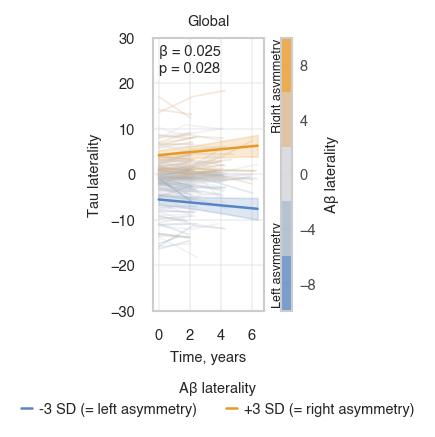

N (A+T-) = 180 (all timepoints = 452)
avg followup years = 2.999
                 Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   tnic_cho_com_I_II_LI
No. Observations:   452       Method:               REML                
No. Groups:         180       Scale:                0.1994              
Min. group size:    2         Log-Likelihood:       -533.1250           
Max. group size:    5         Converged:            Yes                 
Mean group size:    2.5                                                 
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.014    0.106 -0.134 0.894 -0.221  0.193
time                           0.030    0.026  1.150 0.250 -0.021  0.082
age_bas                       -0.013    0.075 -0.176 0.861 -0.161  0.134
gend

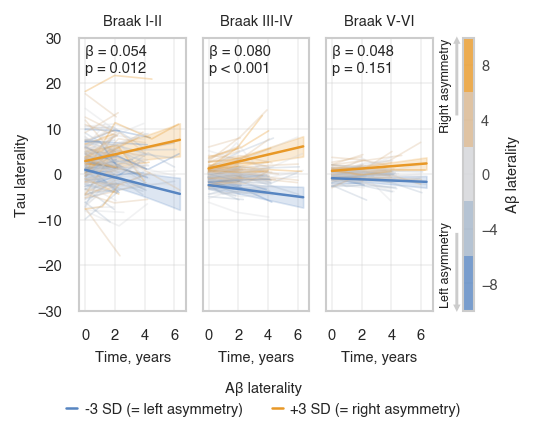

N (A+T+) = 109 (all timepoints = 255)
avg followup years = 2.667
                 Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   tnic_cho_com_I_II_LI
No. Observations:   255       Method:               REML                
No. Groups:         109       Scale:                0.1300              
Min. group size:    2         Log-Likelihood:       -292.6099           
Max. group size:    4         Converged:            Yes                 
Mean group size:    2.3                                                 
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.047    0.121 -0.386 0.700 -0.284  0.190
time                          -0.010    0.036 -0.282 0.778 -0.080  0.060
age_bas                       -0.058    0.089 -0.657 0.511 -0.232  0.116
gend

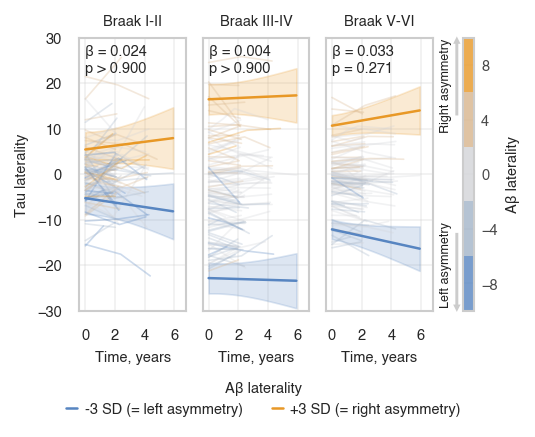

N (A+T- to A+T-) = 142 (all timepoints = 347)
avg followup years = 2.864
                 Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   tnic_cho_com_I_II_LI
No. Observations:   347       Method:               REML                
No. Groups:         142       Scale:                0.2174              
Min. group size:    2         Log-Likelihood:       -414.4307           
Max. group size:    4         Converged:            No                  
Mean group size:    2.4                                                 
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.010    0.121  0.080 0.936 -0.227  0.246
time                           0.036    0.030  1.201 0.230 -0.023  0.096
age_bas                        0.014    0.087  0.161 0.872 -0.157  0.

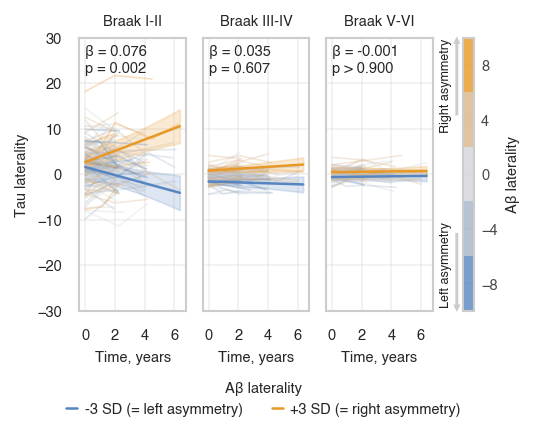

N (A+T- to A+T+) = 38 (all timepoints = 105)
avg followup years = 3.500
                 Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   tnic_cho_com_I_II_LI
No. Observations:   105       Method:               REML                
No. Groups:         38        Scale:                0.1486              
Min. group size:    2         Log-Likelihood:       -124.4198           
Max. group size:    5         Converged:            Yes                 
Mean group size:    2.8                                                 
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.073    0.243 -0.298 0.766 -0.550  0.405
time                          -0.021    0.057 -0.357 0.721 -0.133  0.092
age_bas                       -0.136    0.166 -0.822 0.411 -0.461  0.1

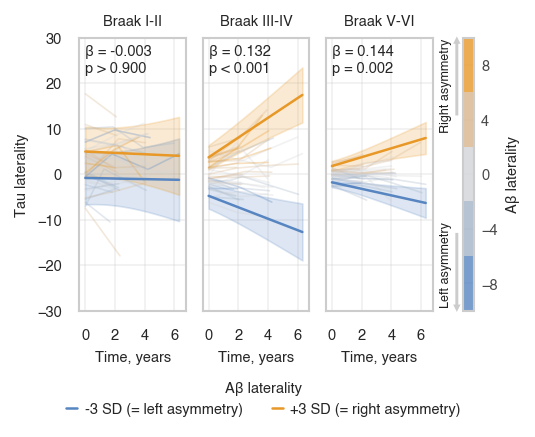

In [7]:
posthoc = True

ROIs_dict = {
    'global': 'Global', 
    'cho_com_I_II': 'Braak I-II', 'cho_com_III_IV': 'Braak III-IV', 'cho_com_V_VI': 'Braak V-VI',
}

set_plot_style(dpi=150)
statann_kwargs = dict(fontsize=7, color='#494949')
line_kwargs = dict(lw=0.8, alpha=0.3)
colors = ['#5785C1FF', '#A3B4C8', '#D3D4D8FF', '#D8B58C', '#E89826']
cmap = ListedColormap(colors, name="BlueToGrayToOrange")

for grp, grp_data in plots_rois_dict.items():

    df_g = grp_data['df']
    rois_dict = grp_data['rois']

    print(f"N ({grp}) = {len(df_g['mid'].unique())} (all timepoints = {len(df_g)})")

    _w = 110/4.1
    _w_ratio = [*[1] * len(rois_dict), 0.1]

    fig = plt.figure(figsize=(_w*(len(rois_dict)+0.1)/25.4, 60/25.4))
    gs = fig.add_gridspec(1, len(rois_dict)+1, width_ratios=_w_ratio, wspace=0.2)
    axs = []
    for i in range(len(rois_dict)):
        axs.append(fig.add_subplot(gs[0, i]))

    all_stats = {}
    for i, (ROI, ROI_name) in enumerate(rois_dict.items()):
        
        # define the tau and ab columns
        tau_reg = f'{tau_prefix}_{ROI}_LI'
        amy_reg = f'{amy_prefix}_{ROI}_LI'

        df_roi = df_g.copy()

        tau_lim, amy_lim = [-30, 30], [-10, 10]

        df_lme = df_roi[['mid', 'time', 'age_bas', 'gender_baseline_variable', tau_reg, amy_reg]].copy()
        df_lme[f'{amy_reg}_bas'] = df_lme.groupby('mid')[amy_reg].transform(lambda x: x.iloc[0])

        avg_fup = df_lme.groupby('mid')['time'].transform(lambda x: x.iloc[-1:]).mean()
        if i==0: print(f'avg followup years = {avg_fup:.3f}')

        # Store original values before z-scoring
        orig_means = df_lme[['age_bas', f'{tau_reg}', f'{amy_reg}_bas']].mean()
        orig_stds = df_lme[['age_bas', f'{tau_reg}', f'{amy_reg}_bas']].std()

        # Z-score the continuous variables
        cols_to_zscore = ['age_bas', f'{tau_reg}', f'{amy_reg}_bas']
        df_lme_z = df_lme.copy()
        df_lme_z[cols_to_zscore] = df_lme_z[cols_to_zscore].apply(zscore)

        # fit the LME
        formula = f"{tau_reg} ~ time * (age_bas + gender_baseline_variable + {amy_reg}_bas)"
        model = smf.mixedlm(formula, data=df_lme_z, groups="mid", re_formula="~time")
        results = model.fit()

        print(results.summary())
        
        ### plotting

        ax = axs[i]

        # define time range for prediction
        time_min, time_max = df_lme['time'].min(), df_lme['time'].max()
        time_range = np.linspace(time_min, time_max, 100)

        # define two amyloid LI values for prediction
        amy_minmax = [-3*df_lme[f'{amy_reg}_bas'].std(), 3*df_lme[f'{amy_reg}_bas'].std()]
        colors = [cmap(0.01), cmap(0.99)]
        labels = [f'-3 SD (= left asymmetry)', f'+3 SD (= right asymmetry)']

        # get covariance matrix of the fixed effects parameters
        fixed_effects_cov = results.cov_params().iloc[:8, :8] #[:6, :6]

        # plot the individual datapoints as spaghetti plot
        for subject in df_lme['mid'].unique():
            subject_data = df_lme[df_lme['mid'] == subject]
            ax.plot(subject_data['time'], subject_data[tau_reg],
                    c=cmap((subject_data[f'{amy_reg}_bas'].mean() - amy_lim[0])/(amy_lim[1] - amy_lim[0])),
                    **line_kwargs)
        
        # plt.ylim([-1.1*df_lme[tau_reg].abs().max(), 1.1*df_lme[tau_reg].abs().max()])
        ax.set_ylim(tau_lim)

        # run prediction with two predefined amyloid LIs
        for amy_val, color, label in zip(amy_minmax, colors, labels):
            # Create prediction data (z-scored)
            temp_data = pd.DataFrame({
                'time': time_range,
                'age_bas': [(df_lme['age_bas'].mean() - orig_means['age_bas'])/orig_stds['age_bas']] * len(time_range),
                'gender_baseline_variable': [df_lme['gender_baseline_variable'].mode()[0]] * len(time_range),
                f'{amy_reg}_bas': [(amy_val - orig_means[f'{amy_reg}_bas'])/orig_stds[f'{amy_reg}_bas']] * len(time_range)
            })

            # Get predictions and transform back to original scale
            pred_mean = results.predict(temp_data)
            pred_mean_orig = pred_mean * orig_stds[f'{tau_reg}'] + orig_means[f'{tau_reg}']

            # Calculate confidence intervals
            design_matrix = np.asarray(patsy.dmatrix(formula.split('~')[1], data=temp_data))
            prediction_var = np.diag(design_matrix @ fixed_effects_cov @ design_matrix.T)
            se = np.sqrt(prediction_var)

            # Transform CIs back to original scale
            lower_ci = (pred_mean - 1.96 * se) * orig_stds[f'{tau_reg}'] + orig_means[f'{tau_reg}']
            upper_ci = (pred_mean + 1.96 * se) * orig_stds[f'{tau_reg}'] + orig_means[f'{tau_reg}']

            # Plot
            ax.plot(time_range, pred_mean_orig, color=color, linewidth=1.2, label=label)
            ax.fill_between(time_range, lower_ci, upper_ci, color=color, alpha=0.2)
        
        if i > 0:
            ax.set_ylabel('')
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('Tau laterality')
        ax.set_title(ROI_name)

        # add annotation of the interaction effect
        interaction_idx = results.model.exog_names.index('time:' + f'{amy_reg}_bas')
        all_stats.update({
            ROI_name: {
                'beta': results.params[interaction_idx],
                'pval': results.pvalues[interaction_idx]
            }
        })

        # last iteration
        if i == len(rois_dict)-1:
            # asymmetry direction arrows
            yrange = tau_lim[1] - tau_lim[0]
            arrowprops_kwargs = dict(arrowstyle='simple', color='#CCCCCC', lw=0.01)
            arrowtext_kwargs = dict(color='#212121', rotation=90, fontsize=6, ha='center', va='center', 
                                    transform=ax.get_yaxis_transform())
            ax.annotate('', xy=(1.225, tau_lim[1] + yrange*0.02), xytext=(1.225, tau_lim[1] - yrange*0.3),
                        xycoords=('axes fraction', 'data'), arrowprops=arrowprops_kwargs)
            ax.text(1.125, tau_lim[1] - yrange*0.175, 'Right asymmetry', **arrowtext_kwargs)
            ax.annotate('', xy=(1.225, tau_lim[0] - yrange*0.02), xytext=(1.225, tau_lim[0] + yrange*0.3),
                        xycoords=('axes fraction', 'data'), arrowprops=arrowprops_kwargs)
            ax.text(1.125, tau_lim[0] + yrange*0.17, 'Left asymmetry', **arrowtext_kwargs)

            # colorbar
            cax = fig.add_subplot(gs[0, -1])
            norm2 = plt.Normalize(amy_lim[0], amy_lim[1])

            colors2 = cmap(np.linspace(0, 1, cmap.N))
            colors2[:, -1] = 0.8#line_kwargs['alpha']  # Set alpha value for all colors
            transparent_cmap = matplotlib.colors.ListedColormap(colors2)
            
            sm = plt.cm.ScalarMappable(cmap=transparent_cmap, norm=norm2)
            cbar = plt.colorbar(sm, cax=cax, label='Aβ laterality')
            # cbar.locator = matplotlib.ticker.MaxNLocator(integer=True)
            cbar.locator = matplotlib.ticker.MultipleLocator(4)
            cbar.update_ticks()
            cbar.ax.tick_params(length=0, color='#CCCCCC', labelcolor='#494949')

            pos = cax.get_position()
            cax.set_position([pos.x0 + 0.028, pos.y0, pos.width, pos.height])
        
        ax.set_xlim([-0.4, 6.8])
        ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
        ax.set_xlabel('Time, years')
        
        if i == 0: handles, labels = ax.get_legend_handles_labels()
    
    # interaction term p-values FDR-corrected (based on the meta-ROIs) and added to plot
    all_pvals = [entry['pval'] for entry in all_stats.values()]
    _, all_pvals_fdr, _, _ = multipletests(all_pvals, method='bonferroni')
    for i, key in enumerate(all_stats.keys()):
        all_stats[key]['pval_fdr'] = all_pvals_fdr[i]
    for i, (ROI, ROI_name) in enumerate(rois_dict.items()):
        ax = axs[i]
        beta = all_stats[ROI_name]['beta']
        pval = all_stats[ROI_name]['pval_fdr']
        if pval < 0.001: ptext = '< 0.001'
        elif pval > 0.9: ptext = '> 0.900'
        else: ptext = f'= {pval:.3f}'
        ax.text(0.055, 0.975, f'β = {beta:.3f}\np {ptext}',
                transform=ax.transAxes, verticalalignment='top')

    plt.legend(handles, labels, loc='lower center', frameon=False, title='Aβ laterality', title_fontsize=7, ncol=2,
                handlelength=0.75, handletextpad=0.5, labelspacing=0.5, bbox_to_anchor=(0.5, -0.225), bbox_transform=fig.transFigure)

    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f'LME_tau_ab_laterality_ld_{grp}_{list(rois_dict.keys())}.pdf'), format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    

1. is tau laterality related to cognition? 
    - model 1 - dv vs tau LI

2. is tau laterality related to cognition after adjusting for tau load?
    - model 2 - dv vs tau LI + tau load

3. is amyloid laterality independently related to cognition after adjusting for tau laterality and tau load and amyloid load?
    - model 3 - dv cs amyloid LI + amyloid load + tau LI + tau load

1
N (A+) = 289 (all timepoints = 707)
259
mPACC_v2 ~ time * (age_bas + gender_baseline_variable + tnic_cho_com_I_II_LI_bas)
                 Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      mPACC_v2 
No. Observations:        606          Method:                  REML     
No. Groups:              259          Scale:                   0.1785   
Min. group size:         2            Log-Likelihood:          -689.7751
Max. group size:         4            Converged:               Yes      
Mean group size:         2.3                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.139    0.060  2.292 0.022  0.020  0.257
time                          -0.160    0.029 -5.582 0.000 -0.216 -0.104
age_bas           

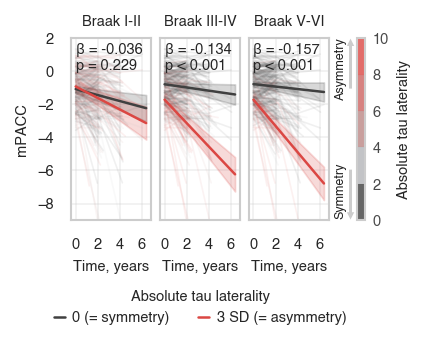

2
N (A+) = 289 (all timepoints = 707)
259
mPACC_v2 ~ time * (age_bas + gender_baseline_variable + tnic_cho_com_I_II_bas + tnic_cho_com_I_II_LI_bas)
                 Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      mPACC_v2 
No. Observations:        606          Method:                  REML     
No. Groups:              259          Scale:                   0.1922   
Min. group size:         2            Log-Likelihood:          -665.3177
Max. group size:         4            Converged:               Yes      
Mean group size:         2.3                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.154    0.057  2.707 0.007  0.043  0.266
time                          -0.153    0.026 -5.828 0.000 -0.204 -

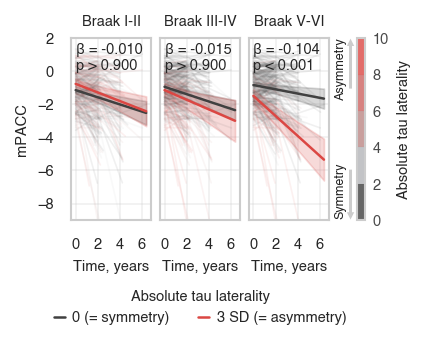

3
N (A+) = 289 (all timepoints = 707)
259
mPACC_v2 ~ time * (age_bas + gender_baseline_variable + fnc_cho_com_I_II_LI_bas)
                 Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      mPACC_v2 
No. Observations:        606          Method:                  REML     
No. Groups:              259          Scale:                   0.1831   
Min. group size:         2            Log-Likelihood:          -691.4184
Max. group size:         4            Converged:               Yes      
Mean group size:         2.3                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.142    0.060  2.343 0.019  0.023  0.260
time                          -0.161    0.029 -5.615 0.000 -0.217 -0.105
age_bas            

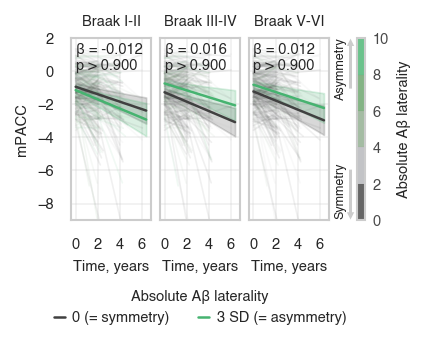

In [8]:
ROIs_dict = {
    'cho_com_I_II': 'Braak I-II', 'cho_com_III_IV': 'Braak III-IV', 'cho_com_V_VI': 'Braak V-VI',
}

label_dict = {
    'mmse_score': 'MMSE', 'mPACC_v2': 'mPACC', 
}
cogtests = ['mPACC_v2']

set_plot_style(dpi=150)
statann_kwargs = dict(fontsize=7, color='#494949')
line_kwargs = dict(lw=0.8, alpha=0.075)

plots_dict_ = {'A+': df_ld_a}

# for iv_type in [amy_prefix, tau_prefix]:
models_dict = {1: tau_prefix, 2: tau_prefix, 3: amy_prefix}
for m, iv_type in models_dict.items():
    print(m)
    if iv_type == tau_prefix: 
        colors = ['#404040', '#B3B4B8', '#BC8785', '#CE6361', '#DB4743']
        cmap = ListedColormap(colors, name="gray2red")
    elif iv_type == amy_prefix: 
        colors = ['#404040', '#B3B4B8', '#8EAB8C', '#66A167', '#46B370']
        cmap = ListedColormap(colors, name="gray2green")
    for dv in cogtests:
        for grp, df_ in plots_dict_.items():
            print(f"N ({grp}) = {len(df_['mid'].unique())} (all timepoints = {len(df_)})")

            fig = plt.figure(figsize=(60/25.4, 40/25.4))
            gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.1], wspace=0.15)
            axs = []
            for i in range(3):
                axs.append(fig.add_subplot(gs[0, i]))

            all_stats = {}
            for i, (ROI, ROI_name) in enumerate(ROIs_dict.items()):

                if iv_type == amy_prefix:
                    covar_li = f'{tau_prefix}_{ROI}_LI'
                    covar_load = f'{tau_prefix}_{ROI}'
                    iv_label = 'Absolute Aβ laterality'
                    iv_lim = [0, 10]
                elif iv_type == tau_prefix:
                    covar_li = f'{amy_prefix}_{ROI}_LI'
                    covar_load = f'{amy_prefix}_{ROI}'
                    iv_label = 'Absolute tau laterality'
                    iv_lim = [0, 10]
                iv_li = f'{iv_type}_{ROI}_LI'
                iv_load = f'{iv_type}_{ROI}'


                df_roi = df_.copy()

                # Set limits based on DV
                if dv == 'mmse_score': dv_lim = [10, 33]
                if dv == 'mPACC_v2': dv_lim = [-9, 2]

                # Prepare data
                df_lme = df_roi[['mid', 'time', 'age_bas', 'gender_baseline_variable', dv, covar_load, iv_load, covar_li, iv_li]].copy()
                df_lme[f'{iv_li}_bas'] = df_lme.groupby('mid')[iv_li].transform(lambda x: x.iloc[0]).abs()
                df_lme[f'{covar_li}_bas'] = df_lme.groupby('mid')[covar_li].transform(lambda x: x.iloc[0]).abs()
                df_lme[f'{iv_load}_bas'] = df_lme.groupby('mid')[iv_load].transform(lambda x: x.iloc[0])
                df_lme[f'{covar_load}_bas'] = df_lme.groupby('mid')[covar_load].transform(lambda x: x.iloc[0])

                df_lme = df_lme.dropna()
                df_lme = df_lme[df_lme.groupby('mid')['mid'].transform('count') > 1]
                
                if i==0: print(len(df_lme['mid'].unique()))

                # Store original values before z-scoring
                orig_means = df_lme[[dv, 'age_bas', f'{covar_load}_bas', f'{iv_load}_bas', f'{covar_li}_bas', f'{iv_li}_bas']].mean()
                orig_stds = df_lme[[dv, 'age_bas', f'{covar_load}_bas', f'{iv_load}_bas', f'{covar_li}_bas', f'{iv_li}_bas']].std()

                # Z-score the continuous variables
                cols_to_zscore = ['age_bas', dv, f'{covar_load}_bas', f'{iv_load}_bas', f'{covar_li}_bas', f'{iv_li}_bas']
                df_lme_z = df_lme.copy()
                df_lme_z[cols_to_zscore] = df_lme_z[cols_to_zscore].apply(zscore)

                # Fit the model
                # formula = f"{dv} ~ time * (age_bas + gender_baseline_variable + {iv_load}_bas + {covar_li}_bas + {iv_li}_bas)"
                if m == 1: 
                    formula = f"{dv} ~ time * (age_bas + gender_baseline_variable + {iv_li}_bas)"
                    n_cov = 8
                elif m == 2: 
                    formula = f"{dv} ~ time * (age_bas + gender_baseline_variable + {iv_load}_bas + {iv_li}_bas)"
                    n_cov = 10
                elif m == 3: 
                    formula = f"{dv} ~ time * (age_bas + gender_baseline_variable + {iv_li}_bas)"
                    n_cov = 8
                print(formula)
                model = smf.mixedlm(formula, data=df_lme_z, groups="mid", re_formula="~time")
                results = model.fit()

                print(results.summary())

                ax = axs[i]

                # Prediction
                time_min, time_max = df_lme['time'].min(), df_lme['time'].max()
                time_range = np.linspace(time_min, time_max, 100)
                amy_minmax = [0, 3*df_lme[f'{iv_li}_bas'].std()]
                # print(amy_minmax)
                colors = [cmap(0.01), cmap(0.99)]
                labels = ['0 (= symmetry)', f'3 SD (= asymmetry)']

                # Plot individual data points (using original scale)
                for subject in df_lme['mid'].unique():
                    subject_data = df_lme[df_lme['mid'] == subject]
                    ax.plot(subject_data['time'], subject_data[dv],
                        # c=cmap((subject_data[f'{iv_li}_bas'].mean() - amy_minmax[0])/(amy_minmax[1] - amy_minmax[0])), # based on the data
                        c=cmap((subject_data[f'{iv_li}_bas'].mean() - iv_lim[0])/(iv_lim[1] - iv_lim[0])), # based on the limits
                        **line_kwargs)

                ax.set_ylim(dv_lim)

                fixed_effects_cov = results.cov_params().iloc[:n_cov, :n_cov]#[:12, :12]

                for amy_val, color, label in zip(amy_minmax, colors, labels):
                    # Create prediction data (z-scored)
                    temp_data = pd.DataFrame({
                        'time': time_range,
                        'age_bas': [(df_lme['age_bas'].mean() - orig_means['age_bas'])/orig_stds['age_bas']] * len(time_range),
                        'gender_baseline_variable': [df_lme['gender_baseline_variable'].mode()[0]] * len(time_range),
                        f'{covar_load}_bas': [(df_lme[f"{covar_load}_bas"].mean() - orig_means[f'{covar_load}_bas'])/orig_stds[f'{covar_load}_bas']] * len(time_range),
                        f'{iv_load}_bas': [(df_lme[f"{iv_load}_bas"].mean() - orig_means[f'{iv_load}_bas'])/orig_stds[f'{iv_load}_bas']] * len(time_range),
                        f'{covar_li}_bas': [(df_lme[f"{covar_li}_bas"].mean() - orig_means[f'{covar_li}_bas'])/orig_stds[f'{covar_li}_bas']] * len(time_range),
                        f'{iv_li}_bas': [(amy_val - orig_means[f'{iv_li}_bas'])/orig_stds[f'{iv_li}_bas']] * len(time_range)
                    })

                    # Get predictions and transform back to original scale
                    pred_mean = results.predict(temp_data)
                    pred_mean_orig = pred_mean * orig_stds[dv] + orig_means[dv]

                    # Calculate confidence intervals
                    design_matrix = np.asarray(patsy.dmatrix(formula.split('~')[1], data=temp_data))
                    prediction_var = np.diag(design_matrix @ fixed_effects_cov @ design_matrix.T)
                    se = np.sqrt(prediction_var)

                    # Transform CIs back to original scale
                    lower_ci = (pred_mean - 1.96 * se) * orig_stds[dv] + orig_means[dv]
                    upper_ci = (pred_mean + 1.96 * se) * orig_stds[dv] + orig_means[dv]

                    # Plot
                    ax.plot(time_range, pred_mean_orig, color=color, linewidth=1.2, label=label)
                    ax.fill_between(time_range, lower_ci, upper_ci, color=color, alpha=0.2)

                # Rest of your plotting code remains the same
                if i > 0:
                    ax.set_ylabel('')
                    ax.set_yticklabels([])
                else:
                    ax.set_ylabel(label_dict[dv])
                ax.set_title(ROI_name)

                # add annotation of the interaction effect
                interaction_idx = results.model.exog_names.index('time:' + f'{iv_li}_bas')
                all_stats.update({
                    ROI_name: {
                        'beta': results.params[interaction_idx],
                        'pval': results.pvalues[interaction_idx]
                    }
                })

                # last iteration
                if i == len(ROIs_dict)-1:
                    # asymmetry direction arrows
                    yrange = dv_lim[1] - dv_lim[0]
                    arrowprops_kwargs = dict(arrowstyle='simple', color='#CCCCCC', lw=0.01)
                    arrowtext_kwargs = dict(color='#212121', rotation=90, fontsize=6, ha='center', va='center', 
                                            transform=ax.get_yaxis_transform())
                    ax.annotate('', xy=(1.275, dv_lim[1] + yrange*0.02), xytext=(1.275, dv_lim[1] - yrange*0.3),
                                xycoords=('axes fraction', 'data'), arrowprops=arrowprops_kwargs)
                    ax.text(1.15, dv_lim[1] - yrange*0.165, 'Asymmetry', **arrowtext_kwargs)
                    ax.annotate('', xy=(1.275, dv_lim[0] - yrange*0.02), xytext=(1.275, dv_lim[0] + yrange*0.3),
                                xycoords=('axes fraction', 'data'), arrowprops=arrowprops_kwargs)
                    ax.text(1.15, dv_lim[0] + yrange*0.165, 'Symmetry', **arrowtext_kwargs)

                    # colorbar
                    cax = fig.add_subplot(gs[0, -1])
                    norm2 = plt.Normalize(iv_lim[0], iv_lim[1]) # based on the limits

                    colors2 = cmap(np.linspace(0, 1, cmap.N))
                    colors2[:, -1] = 0.8#line_kwargs['alpha']  # Set alpha value for all colors
                    transparent_cmap = matplotlib.colors.ListedColormap(colors2)
                    
                    sm = plt.cm.ScalarMappable(cmap=transparent_cmap, norm=norm2)
                    cbar = plt.colorbar(sm, cax=cax, label=iv_label)
                    # cbar.locator = matplotlib.ticker.MaxNLocator(integer=True)
                    cbar.locator = matplotlib.ticker.MultipleLocator(2)
                    cbar.formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

                    cbar.update_ticks()
                    cbar.ax.tick_params(length=0, color='#CCCCCC', labelcolor='#494949')

                    pos = cax.get_position()
                    cax.set_position([pos.x0 + 0.055, pos.y0, pos.width, pos.height])
                
                # ax.set_xlim([-0.5, 6.5])
                ax.set_xlim([-0.4, 6.8])
                ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
                ax.set_xlabel('Time, years')
                if i == 1:
                    ax.legend(loc='lower center', frameon=False, title=iv_label, title_fontsize=7, ncol=2,
                            handlelength=0.75, handletextpad=0.5, labelspacing=0.5, bbox_to_anchor=(0.5, -0.65))
            
            # interaction term p-values FDR-corrected (based on the meta-ROIs) and added to plot
            all_pvals = [entry['pval'] for entry in all_stats.values()]
            _, all_pvals_fdr, _, _ = multipletests(all_pvals, method='bonferroni')
            for i, key in enumerate(all_stats.keys()):
                all_stats[key]['pval_fdr'] = all_pvals_fdr[i]
            for i, (ROI, ROI_name) in enumerate(rois_dict.items()):
                ax = axs[i]
                beta = all_stats[ROI_name]['beta']
                pval = all_stats[ROI_name]['pval_fdr']
                if pval < 0.001: ptext = '< 0.001'
                elif pval > 0.9: ptext = '> 0.900'
                else: ptext = f'= {pval:.3f}'
                ax.text(0.055, 0.975, f'β = {beta:.3f}\np {ptext}',
                        transform=ax.transAxes, verticalalignment='top')
                
            plt.tight_layout()
            plt.savefig(os.path.join(plot_dir, f'LME_m{m}_{grp}_{dv}_{iv_type}_LI_ld.pdf'), format='pdf', bbox_inches='tight', dpi=300)
            plt.show()
